# RAG and prompt automation in dspy

In this notebook, we implement RAG pipeline and RAG compiled with prompt automation with DSPy on Amazon Bedrock. 

We use following models in the notebook. 
- claude-3-sonnet
- claude-3-haiku"
- titan-embed-text-v2
- mistral.mistral-7b-instruct
- llama3-8b-instruct

Acquire [access to models hosted on Amazon Bedrock](https://docs.aws.amazon.com/bedrock/latest/userguide/model-access.html). Choose “Manage model access” in the navigation pane on the Amazon Bedrock console and choose from the list of available options. 

You can select 'us-west-2' region to run this notebook. 

### Environment Setup

Uncomment the following lines if the packages are not installed 

In [1]:
%%capture
!pip3 install langchain
!pip3 install -U langchain-community
!pip3 install pypdf
!pip3 install chromadb
!pip3 install dspy
!pip3 install dspy-ai[faiss-cpu]

In [2]:
import json, os, sys
import io, base64
import pandas as pd
import pathlib
from PIL import Image as PILImage
import unicodedata
from IPython.display import Markdown
import boto3
import dspy
from dspy.teleprompt import BootstrapFewShot
import pandas as pd
import logging
import json, os, shutil
import boto3, re, os, shutil
import matplotlib.pyplot as plt
    

Matplotlib is building the font cache; this may take a moment.


Environment setup : clean up temporary trace files and data files , set up loggers, bedrock session

In [3]:
def clean_up_files_in_dir(dir):
    # cleanup trace files to avoid issues
    if os.path.isdir(dir):
        shutil.rmtree(dir)
    os.mkdir(dir)

In [4]:
clean_up_files_in_dir('./cuad_db')
clean_up_files_in_dir('./trace_files')

In [5]:
# setting logging
logging.basicConfig(filename='lab2_trace.log', 
                    filemode='a', 
                    encoding='utf-8',
                    format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', 
                    level=logging.INFO)

In [6]:
boto_session = boto3.session.Session()
region_name = boto_session.region_name
print(region_name)

session = boto3.Session()

bedrock = session.client("bedrock", region_name=region_name)
br = session.client("bedrock-runtime", region_name=region_name)



us-west-2


### DSPy Language Model and Retriever Model configuration

In [7]:
claude_sonnet_model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
clade_haiku_model_id = "anthropic.claude-3-haiku-20240307-v1:0"
titan_embed_model_id = "amazon.titan-embed-text-v2:0"
mistral_7b_model_id = "mistral.mistral-7b-instruct-v0:2"
llama_8b_model_id = "meta.llama3-8b-instruct-v1:0"

##### DSPy Initialization requires you to explicitly set the reion

In [8]:
dsp_bedrock = dspy.Bedrock(region_name=region_name)

bedrock_sonnet = dspy.AWSAnthropic(aws_provider=dsp_bedrock,
                                  model=claude_sonnet_model_id,
                                  max_new_tokens=4096,
                                  max_tokens=4096)

bedrock_mistral_7b = dspy.AWSMistral(aws_provider=dsp_bedrock,
                                 model=mistral_7b_model_id,
                                 max_new_tokens=4096,
                                 max_tokens=4096)

bedrock_haiku = dspy.AWSAnthropic(aws_provider=dsp_bedrock,
                                 model=clade_haiku_model_id,
                                 max_new_tokens=4096,
                                 max_tokens=4096)

bedrock_llama_8b = dspy.AWSMeta(aws_provider=dsp_bedrock, 
                                model=llama_8b_model_id,
                                max_new_tokens=2048,
                                max_tokens=2048)

### Splitters and chunking configuration    

We will be using the RecursiveCharacterTextSplitter to generate logical and syntactically readable chunks. The size and overlap percentage can be empirically determined based on the dataset. For more flexibility it is possible to generate multiple files from the dataset file and make 1 file 1 chunk.

In [9]:
from langchain.document_loaders import PyPDFLoader, PyPDFDirectoryLoader, CSVLoader
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter

# Load documents 
loader = PyPDFLoader("../cuad_data/ENERGOUSCORP_03_16_2017-EX-10.24-STRATEGIC ALLIANCE AGREEMENT.PDF")
documents = loader.load()

# Split documents by setting chunk size
text_splitter = RecursiveCharacterTextSplitter(
    separators=[
        "\n\n",
        "\n",
        " ",
        ".",
        ",",
        "\u200b",  # Zero-width space
        "\uff0c",  # Fullwidth comma
        "\u3001",  # Ideographic comma
        "\uff0e",  # Fullwidth full stop
        "\u3002",  # Ideographic full stop
        "",
    ],
    chunk_size = 5000,      
    chunk_overlap = 30, 
    length_function=len,
)

docs = text_splitter.split_documents(documents)

### Clean and remove any empty pages in the PDF

In [10]:
print(len(docs))
clean_docs = []
for doc in docs:
    if len(doc.page_content):
        clean_docs.append(doc)

docs = clean_docs
print(len(docs))

32
32


### Setup Retriever on local disk using ChromaDB    

We are using chromaDB to demonstrate the use of vector databases. 

In [12]:
import chromadb
from chromadb.utils import embedding_functions
from chromadb.utils.embedding_functions import AmazonBedrockEmbeddingFunction

bedrock_ef = AmazonBedrockEmbeddingFunction(session=session, model_name=titan_embed_model_id)

bedrock_embeddings = bedrock_ef([doc.page_content for doc in docs])

In [13]:
from dspy.retrieve.chromadb_rm import ChromadbRM

collection_name="contexts"
persist_dir="cuad_db/"

chroma_client = chromadb.PersistentClient(persist_dir)
collection = chroma_client.get_or_create_collection(name=collection_name)

if collection.count() == 0:
    collection.add(embeddings=bedrock_embeddings,
                   documents=[doc.page_content for doc in docs],
                   ids=[str(i) for i in range(len(docs))])

In [14]:
rm = ChromadbRM(collection_name=collection_name, 
                persist_directory=persist_dir, 
                embedding_function=bedrock_ef,
                k=3)

### Dataset setup in DSPy


Contract Understanding Atticus Dataset (CUAD) is a dataset for legal contract review. CUAD was created with dozens of legal experts from The Atticus Project and consists of over 13,000 annotations.


In [15]:
TRN_FILE = '../cuad_data/ENERGOUSCORP_qa.csv'
df_cuad_data = pd.read_csv(TRN_FILE)
df_cuad_data.head()


,index,question,input,answer,qa_id
0,0,What is The name of the contract?,Highlight the parts (if any) of this contract ...,STRATEGIC ALLIANCE AGREEMENT,ENERGOUSCORP_03_16_2017-EX-10.24-STRATEGIC ALL...
1,1,What is The two or more parties who signed the...,Highlight the parts (if any) of this contract ...,"Dialog Semiconductor (UK) Ltd., DIALOG, Energo...",ENERGOUSCORP_03_16_2017-EX-10.24-STRATEGIC ALL...
2,2,What is The date of the contract?,Highlight the parts (if any) of this contract ...,"November 6, 2016",ENERGOUSCORP_03_16_2017-EX-10.24-STRATEGIC ALL...
3,3,What is The date when the contract is effective?,Highlight the parts (if any) of this contract ...,"November 6, 2016",ENERGOUSCORP_03_16_2017-EX-10.24-STRATEGIC ALL...
4,4,On what date will the contract's initial term ...,Highlight the parts (if any) of this contract ...,"Unless earlier terminated as provided herein, ...",ENERGOUSCORP_03_16_2017-EX-10.24-STRATEGIC ALL...


In [16]:
dataset_cuad = []

for index, question, input, answer, qa_id in df_cuad_data.values:
    dataset_cuad.append(dspy.Example(question=question, answer=answer).with_inputs("question"))

trainset = [x.with_inputs('question') for x in dataset_cuad[0:28]]
devset = [x.with_inputs('question') for x in dataset_cuad[28:32]]

### Factuality Judge and Metrics setup (LLM as a judge)

We will now create a Factuality Judge that will adjudicate if the predicted answer factually correct to the groundtruth answer and means the same as the groundtruth answer.

A new factuality metric is created to mark whether the predicted answer is True or not.

In [17]:
class FactJudge(dspy.Signature):
    """Judge if the predicted answer factually correct to the groundtruth answer and same as groundtruth answer. Answer either Factual[True] or Factual[False]"""

    question = dspy.InputField(desc="Question to be answered")
    groundtruth_answer = dspy.InputField(desc="groundtruth answer for the question")
    predicted_answer = dspy.InputField(desc="predicted answer for the question")
    factually_correct = dspy.OutputField(desc="Is the predicted answer factually correct to the groundtruth answer and same as groundtruth answer ?", prefix="Factual[True/False]:")


judge = dspy.ChainOfThought(FactJudge)


def factuality_metric(example, pred):
    factual = judge(question=example.question, groundtruth_answer=example.answer, predicted_answer=pred.answer) #context=pred.context, 
    #logging.info(f"\n factual LLM judge {factual}")
    #logging.info(f"\n example.answer {example.answer}")
    #logging.info(f"\n pred.answer {pred.answer}")
    llm_judge_ans = bool("Factual[True]" in factual.factually_correct 
                         or '100% True' in factual.factually_correct
                         or '100% factually correct' in factual.factually_correct
                         or factual.factually_correct=='True') #or "correct" in factual.factually_correct.lower()
    print(f"llm_judge_ans = {llm_judge_ans}")
    logging.info(f"llm_judge_ans = {llm_judge_ans}")
    return llm_judge_ans

### LLM as a judge evaluation

Let us setup the metric, dataset and RAG pipeline with input and output fields. Then we customize how to validate where we can combine multiple metrics to come up with the final output. 

In [18]:
from dspy.evaluate import Evaluate

# Evaluation
metric_LLM = factuality_metric

evaluate_cuad = Evaluate(devset=dataset_cuad, metric=metric_LLM, num_threads=1, display_progress=True, display_table=0)

### Setup RAG pipeline

In [19]:
# RAG pipeline

class GenerateAnswer(dspy.Signature):
    """Answer questions with short factoid answers."""

    context = dspy.InputField(desc="may contain relevant facts")
    question = dspy.InputField()
    answer = dspy.OutputField(desc="often between 1 and 5 words")

In [20]:
class RAG(dspy.Module):
    def __init__(self, num_passages=3):
        super().__init__()
        self.retrieve = dspy.Retrieve(k=num_passages)
        #self.retrieve = ChromadbRM("contexts", "./chroma", k=num_passages)
        self.generate_answer = dspy.ChainOfThought(GenerateAnswer)
    
    def forward(self, question):
        #context = self.retrieve(question).passages
        context = [unicodedata.normalize("NFKD", r) for r in self.retrieve(question).passages]
        prediction = self.generate_answer(context=context, question=question)
        return dspy.Prediction(context=context, answer=prediction.answer)

In [21]:
def validate_context_and_answer(example, pred, trace=None):
        answer_EM = dspy.evaluate.answer_exact_match(example, pred)
        answer_PM = dspy.evaluate.answer_passage_match(example, pred)
        answer_LLMJudge = factuality_metric(example, pred)

        logging.info(f"\n example question :: {example.question} , example answer :: {example.answer} ")
        logging.info(f"\n pred answer :: {pred.answer}")
        logging.info(f"\n answer_EM :: {answer_EM}, answer_PM ::{answer_PM} answer_LLMJudge :: {answer_LLMJudge}")
        return answer_LLMJudge or answer_EM or answer_PM


### Raw Model Evaluation and Compiled Model Evaluation

We will compare the performance against the raw and compiled DSPy network in this section with different model families and sub-types. Here we try out Haiku, Sonnet and Mistral 7B. This will take some time to run.

In [22]:
def generate_csv(rag_lm, model_id):
    # Loop and generate CSV

    csv_list = list()
    for index, question, input, answer, qa_id in df_cuad_data.values:
        # Get the prediction. This contains `pred.context` and `pred.answer`.
        pred = rag_lm(question)
        csv_list.append([question, answer, pred.answer])

    df = pd.DataFrame(csv_list, columns=['question', 'gt_answer', 'pred_answer'])
    df.to_csv(f"RAG_{model_id}.csv", header=True)

In [ ]:
%%time
# Evaluation

raw_scores = list()
compiled_scores = list()
model_ids = ["anthropic.claude-3-haiku-20240307-v1:0", "anthropic.claude-3-sonnet-20240229-v1:0", "mistral.mistral-7b-instruct-v0:2"]
counter = 0

for lm_id in [bedrock_haiku, bedrock_sonnet, bedrock_mistral_7b]:

    dspy.settings.configure(lm=lm_id)
    dspy.settings.configure(rm=rm)
    rag_lm = RAG()
    print(f"START OF model_id = {model_ids[counter]} --------------->")
    raw_score = evaluate_cuad(rag_lm, num_threads=1)
    raw_scores.append(raw_score)
    
    print(f"raw_score for lm_id = {model_ids[counter]} and raw_score =  {raw_score}")
    logging.info(f"raw_score for lm_id = {model_ids[counter]} and raw_score =  {raw_score}")
    
    # Validation logic: check that the predicted answer is correct.
    # Also check that the retrieved context does actually contain that answer.
    
    # Set up a basic teleprompter, which will compile our RAG program.
    teleprompter = BootstrapFewShot(metric=validate_context_and_answer)
    
    print(f"******* COMPILING model_id = {model_ids[counter]} ******* --------------->")
    # Compile!
    compiled_rag = teleprompter.compile(rag_lm, trainset=trainset)
    
    compiled_score = evaluate_cuad(compiled_rag, num_threads=1)
    compiled_scores.append(compiled_score)
    
    print(f"compiled_score for COMPILED lm_id = {model_ids[counter]} and raw_score =  {compiled_score}")
    logging.info(f"compiled_score for COMPILED lm_id = {model_ids[counter]} and raw_score =  {compiled_score}")
    
    lm_id.inspect_history(n=1)
    generate_csv(rag_lm, model_ids[counter])
    print(f"END OF model_id = {model_ids[counter]} --------------->")
    counter +=1
    

START OF model_id = anthropic.claude-3-haiku-20240307-v1:0 --------------->
  0%|          | 0/32 [00:00<?, ?it/s]

	*** In DSPy 2.5, all LM clients except `dspy.LM` are deprecated, underperform, and are about to be deleted. ***
 		You are using the client AWSAnthropic, which will be removed in DSPy 2.6.
 		Changing the client is straightforward and will let you use new features (Adapters) that improve the consistency of LM outputs, especially when using chat LMs. 

 		Learn more about the changes and how to migrate at
 		https://github.com/stanfordnlp/dspy/blob/main/examples/migration.ipynb


llm_judge_ans = False
  0%|          | 0/32 [00:03<?, ?it/s]

llm_judge_ans = False


Average Metric: 0.00 / 32 (0.0%):   3%|▎         | 1/32 [00:07<01:49,  3.52s/it]

llm_judge_ans = False


Average Metric: 0.00 / 32 (0.0%):   6%|▋         | 2/32 [00:10<01:46,  3.56s/it]

llm_judge_ans = False


Average Metric: 0.00 / 32 (0.0%):   9%|▉         | 3/32 [00:14<01:45,  3.64s/it]

llm_judge_ans = False


Average Metric: 0.00 / 32 (0.0%):  12%|█▎        | 4/32 [00:18<01:45,  3.75s/it]

llm_judge_ans = False


Average Metric: 0.00 / 32 (0.0%):  16%|█▌        | 5/32 [00:22<01:40,  3.73s/it]

llm_judge_ans = True


Average Metric: 1.00 / 32 (3.1%):  19%|█▉        | 6/32 [00:26<01:44,  4.01s/it]

llm_judge_ans = True


Average Metric: 2.00 / 32 (6.2%):  22%|██▏       | 7/32 [00:29<01:36,  3.85s/it]

llm_judge_ans = True


Average Metric: 3.00 / 32 (9.4%):  25%|██▌       | 8/32 [00:35<01:28,  3.69s/it]

llm_judge_ans = True


Average Metric: 4.00 / 32 (12.5%):  28%|██▊       | 9/32 [00:39<01:36,  4.19s/it]

llm_judge_ans = True


Average Metric: 5.00 / 32 (15.6%):  31%|███▏      | 10/32 [00:43<01:32,  4.23s/it]

llm_judge_ans = False


Average Metric: 5.00 / 32 (15.6%):  34%|███▍      | 11/32 [00:47<01:29,  4.25s/it]

llm_judge_ans = True


Average Metric: 6.00 / 32 (18.8%):  38%|███▊      | 12/32 [00:51<01:21,  4.05s/it]

llm_judge_ans = True


Average Metric: 7.00 / 32 (21.9%):  41%|████      | 13/32 [00:54<01:15,  3.95s/it]

llm_judge_ans = True


Average Metric: 8.00 / 32 (25.0%):  44%|████▍     | 14/32 [00:57<01:10,  3.89s/it]

llm_judge_ans = True


Average Metric: 9.00 / 32 (28.1%):  47%|████▋     | 15/32 [01:01<01:02,  3.66s/it]

llm_judge_ans = True


Average Metric: 10.00 / 32 (31.2%):  50%|█████     | 16/32 [01:05<00:57,  3.58s/it]

llm_judge_ans = True


Average Metric: 11.00 / 32 (34.4%):  53%|█████▎    | 17/32 [01:08<00:54,  3.62s/it]

llm_judge_ans = True


Average Metric: 12.00 / 32 (37.5%):  56%|█████▋    | 18/32 [01:12<00:51,  3.65s/it]

llm_judge_ans = True


Average Metric: 13.00 / 32 (40.6%):  59%|█████▉    | 19/32 [01:15<00:46,  3.55s/it]

llm_judge_ans = False


Average Metric: 13.00 / 32 (40.6%):  62%|██████▎   | 20/32 [01:19<00:43,  3.58s/it]

llm_judge_ans = True


Average Metric: 14.00 / 32 (43.8%):  66%|██████▌   | 21/32 [01:23<00:39,  3.58s/it]

llm_judge_ans = True


Average Metric: 15.00 / 32 (46.9%):  69%|██████▉   | 22/32 [01:27<00:36,  3.69s/it]

llm_judge_ans = True


Average Metric: 16.00 / 32 (50.0%):  72%|███████▏  | 23/32 [01:30<00:34,  3.78s/it]

llm_judge_ans = True


Average Metric: 17.00 / 32 (53.1%):  75%|███████▌  | 24/32 [01:34<00:29,  3.75s/it]

llm_judge_ans = True


Average Metric: 18.00 / 32 (56.2%):  78%|███████▊  | 25/32 [01:37<00:24,  3.57s/it]

llm_judge_ans = True


Average Metric: 19.00 / 32 (59.4%):  81%|████████▏ | 26/32 [01:41<00:21,  3.53s/it]

llm_judge_ans = True


Average Metric: 20.00 / 32 (62.5%):  84%|████████▍ | 27/32 [01:45<00:18,  3.67s/it]

llm_judge_ans = False


Average Metric: 20.00 / 32 (62.5%):  88%|████████▊ | 28/32 [01:49<00:14,  3.64s/it]

llm_judge_ans = True


Average Metric: 21.00 / 32 (65.6%):  91%|█████████ | 29/32 [01:53<00:11,  3.85s/it]

llm_judge_ans = True


Average Metric: 22.00 / 32 (68.8%):  94%|█████████▍| 30/32 [01:56<00:07,  3.89s/it]

llm_judge_ans = True


Average Metric: 23.00 / 32 (71.9%):  97%|█████████▋| 31/32 [02:00<00:03,  3.54s/it]

llm_judge_ans = True


Average Metric: 24.00 / 32 (75.0%): 100%|██████████| 32/32 [02:00<00:00,  3.76s/it]

2024/12/18 15:45:06 INFO dspy.evaluate.evaluate: Average Metric: 24 / 32 (75.0%)



raw_score for lm_id = anthropic.claude-3-haiku-20240307-v1:0 and raw_score =  75.0
******* COMPILING model_id = anthropic.claude-3-haiku-20240307-v1:0 ******* --------------->


  4%|▎         | 1/28 [00:03<01:46,  3.96s/it]

llm_judge_ans = False


  7%|▋         | 2/28 [00:07<01:39,  3.83s/it]

llm_judge_ans = True


 11%|█         | 3/28 [00:12<01:43,  4.12s/it]

llm_judge_ans = False


 14%|█▍        | 4/28 [00:15<01:29,  3.72s/it]

llm_judge_ans = False


 18%|█▊        | 5/28 [00:19<01:29,  3.87s/it]

llm_judge_ans = True


 21%|██▏       | 6/28 [00:23<01:27,  3.98s/it]

llm_judge_ans = True


 25%|██▌       | 7/28 [00:27<01:23,  3.95s/it]


llm_judge_ans = True
Bootstrapped 4 full traces after 7 examples for up to 1 rounds, amounting to 7 attempts.
  0%|          | 0/32 [00:05<?, ?it/s]

llm_judge_ans = True


Average Metric: 1.00 / 32 (3.1%):   3%|▎         | 1/32 [00:10<02:35,  5.01s/it]

llm_judge_ans = True


Average Metric: 2.00 / 32 (6.2%):   6%|▋         | 2/32 [00:16<02:44,  5.48s/it]

llm_judge_ans = False


Average Metric: 2.00 / 32 (6.2%):   9%|▉         | 3/32 [00:23<02:42,  5.60s/it]

llm_judge_ans = False


Average Metric: 2.00 / 32 (6.2%):  12%|█▎        | 4/32 [00:29<02:48,  6.03s/it]

llm_judge_ans = True


Average Metric: 3.00 / 32 (9.4%):  16%|█▌        | 5/32 [00:35<02:45,  6.13s/it]

llm_judge_ans = True


Average Metric: 4.00 / 32 (12.5%):  19%|█▉        | 6/32 [00:41<02:34,  5.94s/it]

llm_judge_ans = True


Average Metric: 5.00 / 32 (15.6%):  22%|██▏       | 7/32 [00:47<02:31,  6.05s/it]

llm_judge_ans = True


Average Metric: 6.00 / 32 (18.8%):  25%|██▌       | 8/32 [00:53<02:25,  6.04s/it]

llm_judge_ans = True


Average Metric: 7.00 / 32 (21.9%):  28%|██▊       | 9/32 [00:59<02:21,  6.14s/it]

llm_judge_ans = True


Average Metric: 8.00 / 32 (25.0%):  31%|███▏      | 10/32 [01:06<02:15,  6.15s/it]

llm_judge_ans = False


Average Metric: 8.00 / 32 (25.0%):  34%|███▍      | 11/32 [01:12<02:12,  6.29s/it]

llm_judge_ans = True


Average Metric: 9.00 / 32 (28.1%):  38%|███▊      | 12/32 [01:18<02:03,  6.17s/it]

llm_judge_ans = True


Average Metric: 10.00 / 32 (31.2%):  41%|████      | 13/32 [01:24<01:57,  6.18s/it]

llm_judge_ans = True


Average Metric: 11.00 / 32 (34.4%):  44%|████▍     | 14/32 [01:30<01:48,  6.04s/it]

llm_judge_ans = True


Average Metric: 12.00 / 32 (37.5%):  47%|████▋     | 15/32 [01:36<01:42,  6.05s/it]

llm_judge_ans = True


Average Metric: 13.00 / 32 (40.6%):  50%|█████     | 16/32 [01:42<01:36,  6.03s/it]

llm_judge_ans = True


Average Metric: 14.00 / 32 (43.8%):  53%|█████▎    | 17/32 [01:49<01:32,  6.17s/it]

llm_judge_ans = True


Average Metric: 15.00 / 32 (46.9%):  56%|█████▋    | 18/32 [01:54<01:27,  6.23s/it]

llm_judge_ans = True


Average Metric: 16.00 / 32 (50.0%):  59%|█████▉    | 19/32 [02:00<01:18,  6.05s/it]

llm_judge_ans = False


Average Metric: 16.00 / 32 (50.0%):  62%|██████▎   | 20/32 [02:07<01:10,  5.92s/it]

llm_judge_ans = True


Average Metric: 17.00 / 32 (53.1%):  66%|██████▌   | 21/32 [02:14<01:07,  6.12s/it]

llm_judge_ans = True


Average Metric: 18.00 / 32 (56.2%):  69%|██████▉   | 22/32 [02:20<01:05,  6.51s/it]

llm_judge_ans = True


Average Metric: 19.00 / 32 (59.4%):  72%|███████▏  | 23/32 [02:25<00:56,  6.23s/it]

llm_judge_ans = True


Average Metric: 20.00 / 32 (62.5%):  75%|███████▌  | 24/32 [02:31<00:48,  6.04s/it]

llm_judge_ans = True


Average Metric: 21.00 / 32 (65.6%):  78%|███████▊  | 25/32 [02:38<00:42,  6.01s/it]

llm_judge_ans = True


Average Metric: 22.00 / 32 (68.8%):  81%|████████▏ | 26/32 [02:44<00:36,  6.16s/it]

llm_judge_ans = True


Average Metric: 23.00 / 32 (71.9%):  84%|████████▍ | 27/32 [02:50<00:31,  6.26s/it]

llm_judge_ans = False


Average Metric: 23.00 / 32 (71.9%):  88%|████████▊ | 28/32 [02:57<00:24,  6.24s/it]

llm_judge_ans = False


Average Metric: 23.00 / 32 (71.9%):  91%|█████████ | 29/32 [03:03<00:18,  6.27s/it]

llm_judge_ans = True


Average Metric: 24.00 / 32 (75.0%):  94%|█████████▍| 30/32 [03:10<00:12,  6.27s/it]

llm_judge_ans = True


Average Metric: 25.00 / 32 (78.1%):  97%|█████████▋| 31/32 [03:17<00:06,  6.52s/it]

llm_judge_ans = True


Average Metric: 26.00 / 32 (81.2%): 100%|██████████| 32/32 [03:17<00:00,  6.17s/it]

2024/12/18 15:48:51 INFO dspy.evaluate.evaluate: Average Metric: 26 / 32 (81.2%)



compiled_score for COMPILED lm_id = anthropic.claude-3-haiku-20240307-v1:0 and raw_score =  81.25





Human: Judge if the predicted answer factually correct to the groundtruth answer and same as groundtruth answer. Answer either Factual[True] or Factual[False]

---

Follow the following format.

Question: Question to be answered

Groundtruth Answer: groundtruth answer for the question

Predicted Answer: predicted answer for the question

Reasoning: Let's think step by step in order to ${produce the factually_correct}. We ...

Factual[True/False]: Is the predicted answer factually correct to the groundtruth answer and same as groundtruth answer ?

---

Question: Is there a requirement for insurance that must be maintained by one party for the benefit of the counterparty?

Groundtruth Answer: Each party will maintain, during the Term and for three (3) years thereafter, such comprehensive general liability insurance (including without limitation, products liability) as will adequately p

llm_judge_ans = False


Average Metric: 0.00 / 32 (0.0%):   3%|▎         | 1/32 [00:14<02:56,  5.69s/it]

llm_judge_ans = True


Average Metric: 1.00 / 32 (3.1%):   6%|▋         | 2/32 [00:21<03:48,  7.61s/it]

llm_judge_ans = False


Average Metric: 1.00 / 32 (3.1%):   9%|▉         | 3/32 [00:27<03:36,  7.45s/it]

llm_judge_ans = False


Average Metric: 1.00 / 32 (3.1%):  12%|█▎        | 4/32 [00:36<03:10,  6.80s/it]

llm_judge_ans = False


Average Metric: 1.00 / 32 (3.1%):  16%|█▌        | 5/32 [00:41<03:20,  7.41s/it]

llm_judge_ans = False


Average Metric: 1.00 / 32 (3.1%):  19%|█▉        | 6/32 [00:48<02:55,  6.76s/it]

llm_judge_ans = True


Average Metric: 2.00 / 32 (6.2%):  22%|██▏       | 7/32 [00:54<02:46,  6.66s/it]

llm_judge_ans = False


Average Metric: 2.00 / 32 (6.2%):  25%|██▌       | 8/32 [01:00<02:40,  6.68s/it]

llm_judge_ans = True


Average Metric: 3.00 / 32 (9.4%):  28%|██▊       | 9/32 [01:08<02:25,  6.35s/it]

llm_judge_ans = True


Average Metric: 4.00 / 32 (12.5%):  31%|███▏      | 10/32 [01:13<02:32,  6.93s/it]

llm_judge_ans = False


Average Metric: 4.00 / 32 (12.5%):  34%|███▍      | 11/32 [01:17<02:12,  6.29s/it]

llm_judge_ans = False


Average Metric: 4.00 / 32 (12.5%):  38%|███▊      | 12/32 [01:23<01:53,  5.67s/it]

llm_judge_ans = True


Average Metric: 5.00 / 32 (15.6%):  41%|████      | 13/32 [01:28<01:50,  5.79s/it]

llm_judge_ans = False


Average Metric: 5.00 / 32 (15.6%):  44%|████▍     | 14/32 [01:35<01:39,  5.52s/it]

llm_judge_ans = True


Average Metric: 6.00 / 32 (18.8%):  47%|████▋     | 15/32 [01:43<01:41,  5.99s/it]

llm_judge_ans = True


Average Metric: 7.00 / 32 (21.9%):  50%|█████     | 16/32 [01:49<01:42,  6.40s/it]

llm_judge_ans = False


Average Metric: 7.00 / 32 (21.9%):  53%|█████▎    | 17/32 [01:55<01:35,  6.38s/it]

llm_judge_ans = False


Average Metric: 7.00 / 32 (21.9%):  56%|█████▋    | 18/32 [02:00<01:26,  6.21s/it]

llm_judge_ans = True


Average Metric: 8.00 / 32 (25.0%):  59%|█████▉    | 19/32 [02:06<01:18,  6.04s/it]

llm_judge_ans = True


Average Metric: 9.00 / 32 (28.1%):  62%|██████▎   | 20/32 [02:11<01:10,  5.89s/it]

llm_judge_ans = True


Average Metric: 10.00 / 32 (31.2%):  66%|██████▌   | 21/32 [02:16<01:03,  5.74s/it]

llm_judge_ans = True


Average Metric: 11.00 / 32 (34.4%):  69%|██████▉   | 22/32 [02:22<00:54,  5.41s/it]

llm_judge_ans = True


Average Metric: 12.00 / 32 (37.5%):  72%|███████▏  | 23/32 [02:28<00:50,  5.65s/it]

llm_judge_ans = True


Average Metric: 13.00 / 32 (40.6%):  75%|███████▌  | 24/32 [02:32<00:44,  5.53s/it]

llm_judge_ans = False


Average Metric: 13.00 / 32 (40.6%):  78%|███████▊  | 25/32 [02:40<00:36,  5.22s/it]

llm_judge_ans = True


Average Metric: 14.00 / 32 (43.8%):  81%|████████▏ | 26/32 [02:47<00:36,  6.05s/it]

llm_judge_ans = True


Average Metric: 15.00 / 32 (46.9%):  84%|████████▍ | 27/32 [02:52<00:31,  6.23s/it]

llm_judge_ans = False


Average Metric: 15.00 / 32 (46.9%):  88%|████████▊ | 28/32 [03:00<00:23,  5.96s/it]

llm_judge_ans = False


Average Metric: 15.00 / 32 (46.9%):  91%|█████████ | 29/32 [03:06<00:19,  6.59s/it]

llm_judge_ans = True


Average Metric: 16.00 / 32 (50.0%):  94%|█████████▍| 30/32 [03:12<00:12,  6.42s/it]

llm_judge_ans = True


Average Metric: 17.00 / 32 (53.1%):  97%|█████████▋| 31/32 [03:20<00:06,  6.33s/it]

llm_judge_ans = True


Average Metric: 18.00 / 32 (56.2%): 100%|██████████| 32/32 [03:20<00:00,  6.26s/it]

2024/12/18 15:53:16 INFO dspy.evaluate.evaluate: Average Metric: 18 / 32 (56.2%)



raw_score for lm_id = anthropic.claude-3-sonnet-20240229-v1:0 and raw_score =  56.25
******* COMPILING model_id = anthropic.claude-3-sonnet-20240229-v1:0 ******* --------------->


  4%|▎         | 1/28 [00:07<03:30,  7.79s/it]

llm_judge_ans = False


  7%|▋         | 2/28 [00:16<03:41,  8.54s/it]

llm_judge_ans = False


 11%|█         | 3/28 [00:26<03:46,  9.05s/it]

llm_judge_ans = False


 14%|█▍        | 4/28 [00:35<03:41,  9.21s/it]

llm_judge_ans = True


 18%|█▊        | 5/28 [00:48<04:03, 10.59s/it]

llm_judge_ans = False


 21%|██▏       | 6/28 [00:58<03:46, 10.31s/it]

llm_judge_ans = False


 25%|██▌       | 7/28 [01:08<03:33, 10.17s/it]

llm_judge_ans = True


 29%|██▊       | 8/28 [01:16<03:07,  9.35s/it]

llm_judge_ans = True


 32%|███▏      | 9/28 [01:27<03:03,  9.68s/it]


llm_judge_ans = True
Bootstrapped 4 full traces after 9 examples for up to 1 rounds, amounting to 9 attempts.
  0%|          | 0/32 [00:12<?, ?it/s]

llm_judge_ans = True


Average Metric: 1.00 / 32 (3.1%):   3%|▎         | 1/32 [00:27<06:33, 12.69s/it]

llm_judge_ans = False


Average Metric: 1.00 / 32 (3.1%):   6%|▋         | 2/32 [00:50<07:04, 14.16s/it]

llm_judge_ans = True


Average Metric: 2.00 / 32 (6.2%):   9%|▉         | 3/32 [01:10<08:38, 17.87s/it]

llm_judge_ans = True


Average Metric: 3.00 / 32 (9.4%):  12%|█▎        | 4/32 [01:51<08:49, 18.92s/it]

llm_judge_ans = True


Average Metric: 4.00 / 32 (12.5%):  16%|█▌        | 5/32 [02:36<12:01, 26.71s/it]

llm_judge_ans = True


Average Metric: 5.00 / 32 (15.6%):  19%|█▉        | 6/32 [02:36<14:15, 32.89s/it]

2024/12/18 15:57:35 ERROR dspy.utils.parallelizer: Error processing item Example({'question': 'What is the notice period required to terminate renewal?', 'answer': 'Unless earlier terminated as provided herein, this Agreement continues in effect for an initial term of seven (7) years ("Initial Term") and will automatically renew for one or more annual periods after the Initial Term (each a "Renewal Term") unless either party gives notice of non-renewal at least one hundred eighty (180) days prior to the beginning of any Renewal Term.'}) (input_keys={'question'}): An error occurred (ServiceUnavailableException) when calling the InvokeModel operation (reached max retries: 4): Bedrock is unable to process your request.. Set `provide_traceback=True` to see the stack trace.


Average Metric: 5.00 / 32 (15.6%):  22%|██▏       | 7/32 [03:15<11:23, 27.33s/it]

llm_judge_ans = False


Average Metric: 5.00 / 32 (15.6%):  25%|██▌       | 8/32 [03:32<10:27, 26.13s/it]

llm_judge_ans = True


Average Metric: 6.00 / 32 (18.8%):  28%|██▊       | 9/32 [03:48<08:54, 23.26s/it]

llm_judge_ans = True


Average Metric: 7.00 / 32 (21.9%):  31%|███▏      | 10/32 [04:03<07:44, 21.11s/it]

llm_judge_ans = False


Average Metric: 7.00 / 32 (21.9%):  34%|███▍      | 11/32 [04:18<06:42, 19.18s/it]

llm_judge_ans = True


Average Metric: 8.00 / 32 (25.0%):  38%|███▊      | 12/32 [04:31<05:57, 17.86s/it]

llm_judge_ans = True


Average Metric: 9.00 / 32 (28.1%):  41%|████      | 13/32 [04:45<05:12, 16.44s/it]

llm_judge_ans = False


Average Metric: 9.00 / 32 (28.1%):  44%|████▍     | 14/32 [05:04<04:43, 15.73s/it]

llm_judge_ans = True


Average Metric: 10.00 / 32 (31.2%):  47%|████▋     | 15/32 [05:20<04:40, 16.52s/it]

llm_judge_ans = True


Average Metric: 11.00 / 32 (34.4%):  50%|█████     | 16/32 [05:35<04:25, 16.57s/it]

llm_judge_ans = False


Average Metric: 11.00 / 32 (34.4%):  53%|█████▎    | 17/32 [05:50<03:58, 15.89s/it]

llm_judge_ans = True


Average Metric: 12.00 / 32 (37.5%):  56%|█████▋    | 18/32 [06:07<03:39, 15.70s/it]

llm_judge_ans = False


Average Metric: 12.00 / 32 (37.5%):  59%|█████▉    | 19/32 [06:24<03:30, 16.21s/it]

llm_judge_ans = False


Average Metric: 12.00 / 32 (37.5%):  62%|██████▎   | 20/32 [06:42<03:17, 16.43s/it]

llm_judge_ans = True


Average Metric: 13.00 / 32 (40.6%):  66%|██████▌   | 21/32 [06:59<03:05, 16.89s/it]

llm_judge_ans = True


Average Metric: 14.00 / 32 (43.8%):  69%|██████▉   | 22/32 [07:14<02:47, 16.79s/it]

llm_judge_ans = True


Average Metric: 15.00 / 32 (46.9%):  72%|███████▏  | 23/32 [07:29<02:27, 16.36s/it]

llm_judge_ans = False


Average Metric: 15.00 / 32 (46.9%):  75%|███████▌  | 24/32 [07:43<02:07, 15.94s/it]

llm_judge_ans = True


Average Metric: 16.00 / 32 (50.0%):  78%|███████▊  | 25/32 [08:01<01:47, 15.35s/it]

llm_judge_ans = True


Average Metric: 17.00 / 32 (53.1%):  81%|████████▏ | 26/32 [08:16<01:36, 16.05s/it]

llm_judge_ans = True


Average Metric: 18.00 / 32 (56.2%):  84%|████████▍ | 27/32 [08:31<01:19, 15.82s/it]

llm_judge_ans = False


Average Metric: 18.00 / 32 (56.2%):  88%|████████▊ | 28/32 [08:48<01:02, 15.68s/it]

llm_judge_ans = True


Average Metric: 19.00 / 32 (59.4%):  91%|█████████ | 29/32 [09:05<00:48, 16.12s/it]

llm_judge_ans = True


Average Metric: 20.00 / 32 (62.5%):  94%|█████████▍| 30/32 [09:22<00:32, 16.12s/it]

llm_judge_ans = True


Average Metric: 21.00 / 32 (65.6%):  97%|█████████▋| 31/32 [09:36<00:16, 16.61s/it]

llm_judge_ans = False


Average Metric: 21.00 / 32 (65.6%): 100%|██████████| 32/32 [09:36<00:00, 18.03s/it]

2024/12/18 16:04:20 INFO dspy.evaluate.evaluate: Average Metric: 21.0 / 32 (65.6%)



compiled_score for COMPILED lm_id = anthropic.claude-3-sonnet-20240229-v1:0 and raw_score =  65.62





Human: Judge if the predicted answer factually correct to the groundtruth answer and same as groundtruth answer. Answer either Factual[True] or Factual[False]

---

Follow the following format.

Question: Question to be answered

Groundtruth Answer: groundtruth answer for the question

Predicted Answer: predicted answer for the question

Reasoning: Let's think step by step in order to ${produce the factually_correct}. We ...

Factual[True/False]: Is the predicted answer factually correct to the groundtruth answer and same as groundtruth answer ?

---

Question: Is there a requirement for insurance that must be maintained by one party for the benefit of the counterparty?

Groundtruth Answer: Each party will maintain, during the Term and for three (3) years thereafter, such comprehensive general liability insurance (including without limitation, products liability) as will adequately 

llm_judge_ans = False


Average Metric: 4.00 / 32 (12.5%):  28%|██▊       | 9/32 [00:25<01:10,  3.08s/it]

llm_judge_ans = True


Average Metric: 5.00 / 32 (15.6%):  31%|███▏      | 10/32 [00:27<01:06,  3.04s/it]

llm_judge_ans = True


Average Metric: 6.00 / 32 (18.8%):  34%|███▍      | 11/32 [00:29<00:59,  2.86s/it]

llm_judge_ans = False


Average Metric: 6.00 / 32 (18.8%):  38%|███▊      | 12/32 [00:31<00:52,  2.65s/it]

llm_judge_ans = True


Average Metric: 7.00 / 32 (21.9%):  41%|████      | 13/32 [00:34<00:45,  2.41s/it]

llm_judge_ans = False


Average Metric: 7.00 / 32 (21.9%):  44%|████▍     | 14/32 [00:36<00:48,  2.68s/it]

llm_judge_ans = False


Average Metric: 7.00 / 32 (21.9%):  47%|████▋     | 15/32 [00:39<00:40,  2.40s/it]

llm_judge_ans = True


Average Metric: 8.00 / 32 (25.0%):  50%|█████     | 16/32 [00:41<00:40,  2.53s/it]

llm_judge_ans = True


Average Metric: 9.00 / 32 (28.1%):  53%|█████▎    | 17/32 [00:43<00:34,  2.28s/it]

llm_judge_ans = True


Average Metric: 10.00 / 32 (31.2%):  56%|█████▋    | 18/32 [00:45<00:30,  2.21s/it]

llm_judge_ans = True


Average Metric: 11.00 / 32 (34.4%):  59%|█████▉    | 19/32 [00:47<00:29,  2.30s/it]

llm_judge_ans = False


Average Metric: 11.00 / 32 (34.4%):  62%|██████▎   | 20/32 [00:49<00:26,  2.22s/it]

llm_judge_ans = True


Average Metric: 12.00 / 32 (37.5%):  66%|██████▌   | 21/32 [00:52<00:22,  2.04s/it]

llm_judge_ans = False


Average Metric: 12.00 / 32 (37.5%):  69%|██████▉   | 22/32 [00:55<00:23,  2.34s/it]

llm_judge_ans = False


Average Metric: 12.00 / 32 (37.5%):  72%|███████▏  | 23/32 [00:57<00:22,  2.52s/it]

llm_judge_ans = True


Average Metric: 13.00 / 32 (40.6%):  75%|███████▌  | 24/32 [01:01<00:20,  2.51s/it]

llm_judge_ans = True


Average Metric: 14.00 / 32 (43.8%):  78%|███████▊  | 25/32 [01:02<00:19,  2.72s/it]

llm_judge_ans = True


Average Metric: 15.00 / 32 (46.9%):  81%|████████▏ | 26/32 [01:05<00:14,  2.46s/it]

llm_judge_ans = True


Average Metric: 16.00 / 32 (50.0%):  84%|████████▍ | 27/32 [01:09<00:11,  2.38s/it]

llm_judge_ans = False


Average Metric: 16.00 / 32 (50.0%):  88%|████████▊ | 28/32 [01:11<00:11,  2.99s/it]

llm_judge_ans = True


Average Metric: 17.00 / 32 (53.1%):  91%|█████████ | 29/32 [01:14<00:08,  2.79s/it]

llm_judge_ans = True


Average Metric: 18.00 / 32 (56.2%):  94%|█████████▍| 30/32 [01:16<00:05,  2.82s/it]

llm_judge_ans = True


Average Metric: 19.00 / 32 (59.4%):  97%|█████████▋| 31/32 [01:17<00:02,  2.52s/it]

llm_judge_ans = True


Average Metric: 20.00 / 32 (62.5%): 100%|██████████| 32/32 [01:17<00:00,  2.43s/it]

2024/12/18 16:07:12 INFO dspy.evaluate.evaluate: Average Metric: 20 / 32 (62.5%)



raw_score for lm_id = mistral.mistral-7b-instruct-v0:2 and raw_score =  62.5
******* COMPILING model_id = mistral.mistral-7b-instruct-v0:2 ******* --------------->


  4%|▎         | 1/28 [00:02<00:58,  2.18s/it]

llm_judge_ans = False


  7%|▋         | 2/28 [00:04<00:52,  2.00s/it]

llm_judge_ans = True


 11%|█         | 3/28 [00:06<00:53,  2.13s/it]

llm_judge_ans = False


 14%|█▍        | 4/28 [00:08<00:48,  2.00s/it]

llm_judge_ans = True


 18%|█▊        | 5/28 [00:21<02:16,  5.95s/it]

llm_judge_ans = True


 21%|██▏       | 6/28 [00:23<01:27,  3.97s/it]


llm_judge_ans = True
Bootstrapped 4 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.
  0%|          | 0/32 [00:03<?, ?it/s]

llm_judge_ans = False


Average Metric: 0.00 / 32 (0.0%):   3%|▎         | 1/32 [00:07<02:03,  3.98s/it]

llm_judge_ans = True


Average Metric: 1.00 / 32 (3.1%):   6%|▋         | 2/32 [00:11<01:47,  3.57s/it]

llm_judge_ans = False


Average Metric: 1.00 / 32 (3.1%):   9%|▉         | 3/32 [00:15<01:49,  3.77s/it]

llm_judge_ans = False


Average Metric: 1.00 / 32 (3.1%):  12%|█▎        | 4/32 [00:30<01:53,  4.05s/it]

llm_judge_ans = True


Average Metric: 2.00 / 32 (6.2%):  16%|█▌        | 5/32 [00:38<03:34,  7.96s/it]

llm_judge_ans = True


Average Metric: 3.00 / 32 (9.4%):  19%|█▉        | 6/32 [00:41<03:22,  7.80s/it]

llm_judge_ans = True


Average Metric: 4.00 / 32 (12.5%):  22%|██▏       | 7/32 [00:44<02:40,  6.42s/it]

llm_judge_ans = True


Average Metric: 5.00 / 32 (15.6%):  25%|██▌       | 8/32 [00:56<02:08,  5.36s/it]

llm_judge_ans = True


Average Metric: 6.00 / 32 (18.8%):  28%|██▊       | 9/32 [01:03<02:47,  7.29s/it]

llm_judge_ans = True


Average Metric: 7.00 / 32 (21.9%):  31%|███▏      | 10/32 [01:11<02:41,  7.35s/it]

llm_judge_ans = False


Average Metric: 7.00 / 32 (21.9%):  34%|███▍      | 11/32 [01:22<02:37,  7.50s/it]

llm_judge_ans = False


Average Metric: 7.00 / 32 (21.9%):  38%|███▊      | 12/32 [01:29<02:50,  8.54s/it]

llm_judge_ans = True


Average Metric: 8.00 / 32 (25.0%):  41%|████      | 13/32 [01:37<02:34,  8.13s/it]

llm_judge_ans = True


Average Metric: 9.00 / 32 (28.1%):  44%|████▍     | 14/32 [01:42<02:23,  7.97s/it]

llm_judge_ans = False


Average Metric: 9.00 / 32 (28.1%):  47%|████▋     | 15/32 [01:52<02:02,  7.23s/it]

llm_judge_ans = True


Average Metric: 10.00 / 32 (31.2%):  50%|█████     | 16/32 [01:58<02:07,  7.95s/it]

llm_judge_ans = True


Average Metric: 11.00 / 32 (34.4%):  53%|█████▎    | 17/32 [02:03<01:48,  7.25s/it]

llm_judge_ans = True


Average Metric: 12.00 / 32 (37.5%):  56%|█████▋    | 18/32 [02:09<01:34,  6.74s/it]

llm_judge_ans = True


Average Metric: 13.00 / 32 (40.6%):  59%|█████▉    | 19/32 [02:16<01:22,  6.36s/it]

llm_judge_ans = False


Average Metric: 13.00 / 32 (40.6%):  62%|██████▎   | 20/32 [02:21<01:18,  6.56s/it]

llm_judge_ans = True


Average Metric: 14.00 / 32 (43.8%):  66%|██████▌   | 21/32 [02:30<01:09,  6.32s/it]

llm_judge_ans = True


Average Metric: 15.00 / 32 (46.9%):  69%|██████▉   | 22/32 [02:35<01:10,  7.08s/it]

llm_judge_ans = True


Average Metric: 16.00 / 32 (50.0%):  72%|███████▏  | 23/32 [02:39<00:58,  6.45s/it]

llm_judge_ans = True


Average Metric: 17.00 / 32 (53.1%):  75%|███████▌  | 24/32 [02:47<00:45,  5.75s/it]

llm_judge_ans = False


Average Metric: 17.00 / 32 (53.1%):  78%|███████▊  | 25/32 [02:57<00:45,  6.43s/it]

llm_judge_ans = True


Average Metric: 18.00 / 32 (56.2%):  81%|████████▏ | 26/32 [03:06<00:45,  7.51s/it]

llm_judge_ans = True


Average Metric: 19.00 / 32 (59.4%):  84%|████████▍ | 27/32 [03:11<00:39,  7.93s/it]

llm_judge_ans = True


Average Metric: 20.00 / 32 (62.5%):  88%|████████▊ | 28/32 [03:19<00:28,  7.07s/it]

llm_judge_ans = True


Average Metric: 21.00 / 32 (65.6%):  91%|█████████ | 29/32 [03:27<00:21,  7.24s/it]

llm_judge_ans = True


Average Metric: 22.00 / 32 (68.8%):  94%|█████████▍| 30/32 [03:37<00:15,  7.60s/it]

llm_judge_ans = False


Average Metric: 22.00 / 32 (68.8%):  97%|█████████▋| 31/32 [03:51<00:08,  8.23s/it]

llm_judge_ans = True


Average Metric: 23.00 / 32 (71.9%): 100%|██████████| 32/32 [03:51<00:00,  7.24s/it]

2024/12/18 16:11:27 INFO dspy.evaluate.evaluate: Average Metric: 23 / 32 (71.9%)



compiled_score for COMPILED lm_id = mistral.mistral-7b-instruct-v0:2 and raw_score =  71.88



<s> [INST] Human: Judge if the predicted answer factually correct to the groundtruth answer and same as groundtruth answer. Answer either Factual[True] or Factual[False]

---

Follow the following format.

Question: Question to be answered

Groundtruth Answer: groundtruth answer for the question

Predicted Answer: predicted answer for the question

Reasoning: Let's think step by step in order to ${produce the factually_correct}. We ...

Factual[True/False]: Is the predicted answer factually correct to the groundtruth answer and same as groundtruth answer ?

---

Question: Is there a requirement for insurance that must be maintained by one party for the benefit of the counterparty?

Groundtruth Answer: Each party will maintain, during the Term and for three (3) years thereafter, such comprehensive general liability insurance (including without limitation, products liability) as will adequatel

### Retriever Evaluation (RM is same across models)

In RAG workflows, it is very crucial to understand the retriever performance to be able to improve the performance of the overall system. We will now create a retriever judge to understand how well the retriever is able to pull out the relevant chunks for the incoming user question. Context and Answer relevance is measured using this Retriever Judge.

In [ ]:
class RetreivalJudge(dspy.Signature):
    """Judge given the question to be answered, check if the groundtruth answer can be derived from the predicted context.  Answer either Retrieved[True] or Retrieved[False]"""

    context = dspy.InputField(desc="Context for the prediction")
    question = dspy.InputField(desc="Question to be answered")
    groundtruth_answer = dspy.InputField(desc="groundtruth answer for the question")
    retrieval_correctness = dspy.OutputField(desc="Can the groundtruth answer be derived from the predicted context?", prefix="Retrieved[True/False]:")

retreival_judge = dspy.ChainOfThought(RetreivalJudge)


def retrieval_metric(example, pred):
    retrieval = retreival_judge(question=example.question, groundtruth_answer=example.answer, context=pred.context) 
    #logging.info(f"\n retrieval LLM judge {retrieval}")
    #logging.info(f"\n example {example}")
    #logging.info(f"\n pred {pred}")
    llm_retreiver_ans = bool("Retrieved[True]" in retrieval.retrieval_correctness 
                         or '100% True' in retrieval.retrieval_correctness
                         or '100% retrieved correct' in retrieval.retrieval_correctness
                         or 'True.' in retrieval.retrieval_correctness) 
    #logging.info(f"llm_retreiver_ans = {llm_retreiver_ans}")
    return llm_retreiver_ans

In [ ]:
def answer_passages_retrieved(example, pred, trace=None):
    gt_answer = example['answer']
    pred_context = set(map(dspy.evaluate.normalize_text, [c.split(' | ')[0] for c in pred.context]))
    logging.info(f"example['answer'] :: {example['answer']}")
    logging.info(f"gt_answer :: {gt_answer}")
    #logging.info(f"pred_context :: {pred_context}")
    return gt_answer.issubset(pred_context)

compiled_rag_retrieval_score = evaluate_cuad(compiled_rag, num_threads = 1, metric=retrieval_metric)
compiled_rag_retrieval_score

Average Metric: 29.00 / 32 (90.6%): 100%|██████████| 32/32 [04:01<00:00,  7.55s/it]

2024/12/18 16:16:08 INFO dspy.evaluate.evaluate: Average Metric: 29 / 32 (90.6%)


90.62

### RAG performance across models

Let us see the performance across various model familes and types using raw and compiled DSPy framework to understand what value DSPy may bring to the table. 

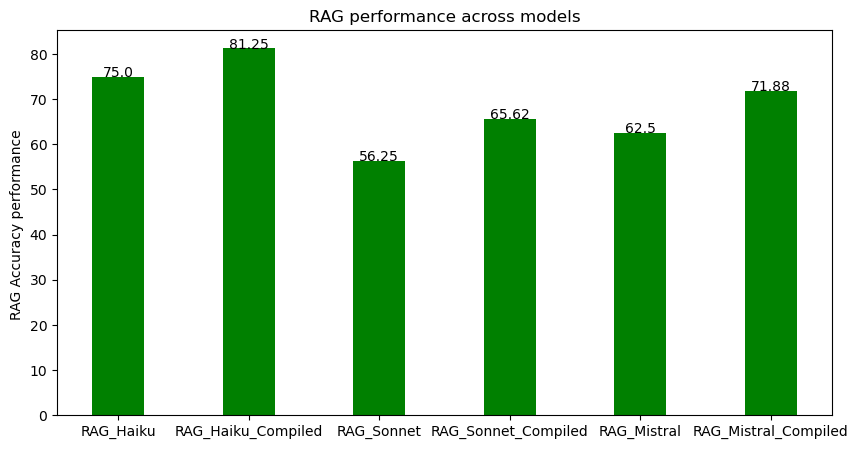

In [ ]:
class_type = ['RAG_Haiku','RAG_Haiku_Compiled','RAG_Sonnet','RAG_Sonnet_Compiled','RAG_Mistral','RAG_Mistral_Compiled']
class_count = [raw_scores[0],compiled_scores[0],raw_scores[1],compiled_scores[1],raw_scores[2],compiled_scores[2]]

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(class_type, class_count, color ='green', width = 0.4)

for i in range(len(class_type)):
        plt.text(i,class_count[i],class_count[i], ha = 'center')

plt.xlabel("")
plt.ylabel("RAG Accuracy performance ")
plt.title("RAG performance across models")
plt.show()